In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!kaggle competitions download -c nyc-taxi-trip-duration

In [ ]:
import shutil
shutil.unpack_archive('nyc-taxi-trip-duration.zip')

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
df = df.drop('dropoff_datetime', axis=1)

In [ ]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

In [ ]:
df = df.sort_values(by='pickup_datetime')

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736


In [ ]:
df_train = df[:10 ** 6]
df_test = df[10 ** 6:]

<Axes: >

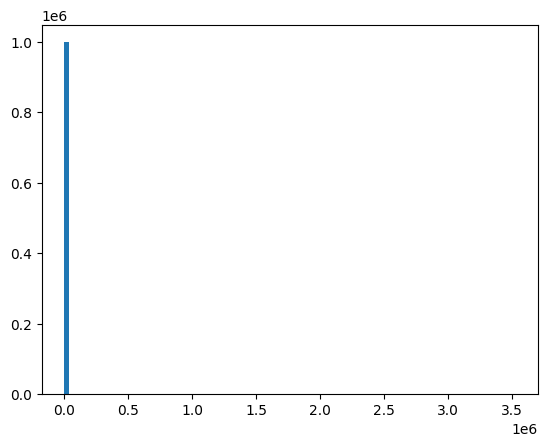

In [ ]:
df_train.trip_duration.hist(bins=100, grid=False, )

Попробуем взять `log(1 + x)`

<Axes: >

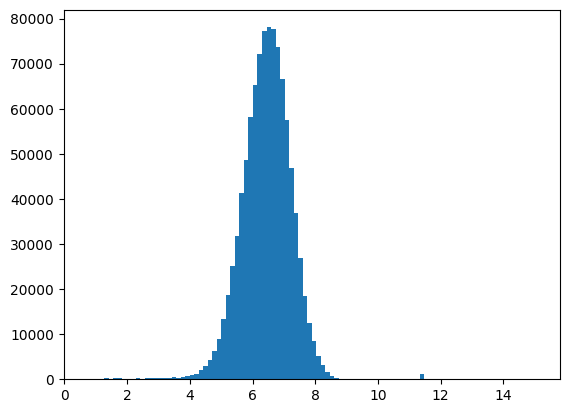

In [ ]:
import numpy as np
np.log1p(df_train.trip_duration).hist(bins=100, grid=False, )

In [ ]:
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)

In [ ]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Распределения признаков.

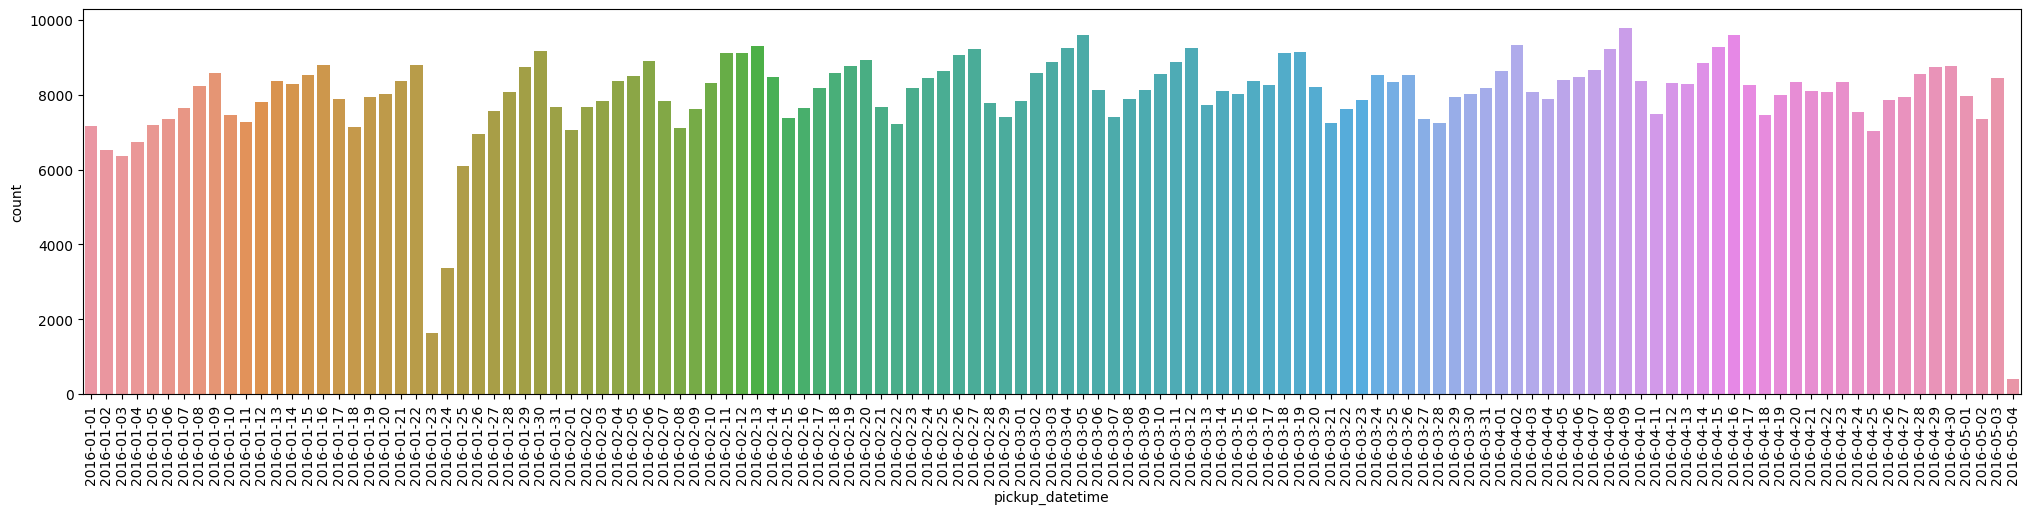

In [ ]:
date_sorted = df_train.pickup_datetime.apply(lambda x: x.date()).sort_values()

plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(
  x=date_sorted,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);

<Axes: xlabel='pickup_datetime', ylabel='count'>

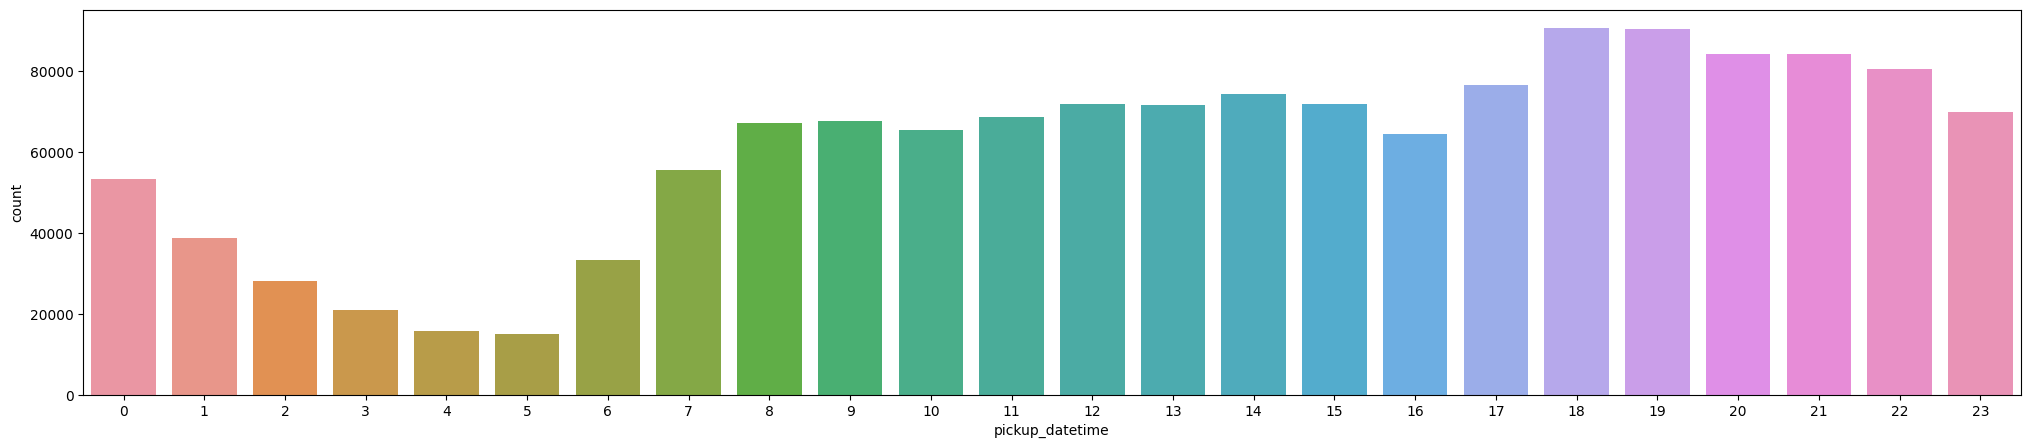

In [ ]:
plt.figure(figsize=(25, 5))
sns.countplot(
  x=df.pickup_datetime.apply(lambda x: x.hour),
)

Теперь давайте посмотрим, как связан день и длина поездки.

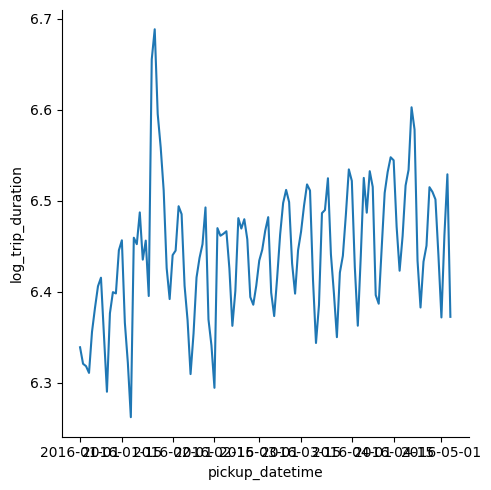

In [ ]:
group_by_weekday = df_train.groupby(df_train.pickup_datetime.apply(lambda x: x.date()))
sns.relplot(data=group_by_weekday.log_trip_duration.aggregate('mean'), kind='line');

Используем день и час.

In [ ]:
import datetime
def create_features(data_frame):
  X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
     ], axis=1, keys=['day', 'hour',]
  )

  return X, data_frame.log_trip_duration

In [ ]:
X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)

In [ ]:
X_train.head()

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0


Кодрование категорий.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1])], remainder="passthrough")

In [ ]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Воспользуемся классом `Ridge` и обучим модель.

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

In [ ]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [ ]:
mean_squared_error(ridge.predict(X_test), y_test)

0.6539687819760848

Подбор гиперпараметров

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_searcher = GridSearchCV(Ridge(),
                             param_grid={'alpha': np.linspace(100, 750, 10)},
                             cv=5).fit(X_train, y_train)

In [ ]:
mean_squared_error(grid_searcher.predict(X_test), y_test)

0.6538784861219816

In [ ]:
grid_searcher.best_params_

{'alpha': 388.8888888888889}

График соответствующий количеству поездок в зависимости от дня недели по обучающей выборке.


<Axes: xlabel='pickup_datetime', ylabel='count'>

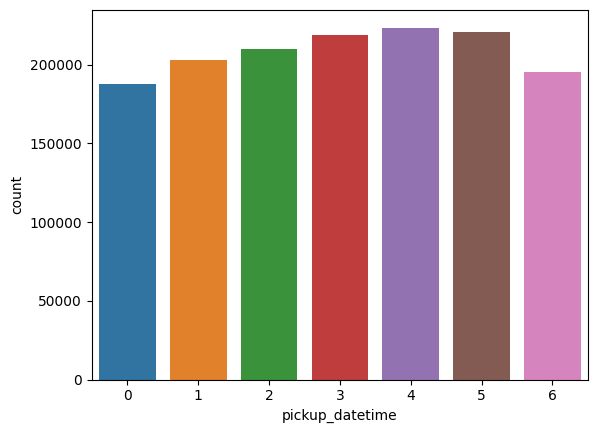

In [ ]:
sns.countplot(
  x=df.pickup_datetime.apply(lambda x: x.dayofweek),
)

Добавляем день недели.

In [ ]:
def create_features(data_frame):
  X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
      data_frame.pickup_datetime.apply(lambda x: x.dayofweek)
     ], axis=1, keys=['day', 'hour', 'weekday',]
  )

  return X, data_frame.log_trip_duration

In [ ]:
X_train, y_train = create_features(df_train)
X_test, y_test = create_features(df_test)

In [ ]:
X_train.head()

,day,hour,weekday
96469,1,0,4
223872,1,0,4
713067,1,0,4
652463,1,0,4
722901,1,0,4


In [ ]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse_output=False),[1,2])], remainder="passthrough")

In [ ]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [ ]:
X_train[:,31]

array([-1.776795, -1.776795, -1.776795, ..., 1.731355, 1.731355, 1.731355])

Масштабирование дня и обучение Lasso.



In [ ]:
X_train[:,31]=(X_train[:,31]-np.mean(X_train[:,31]))/np.std(X_train[:,31])

In [ ]:
lasso = Lasso(alpha=2.65e-05).fit(X_train, y_train)

In [ ]:
mean_squared_error(lasso.predict(X_test), y_test)

18.705908027630365

In [ ]:
abs(lasso.coef_)<(0.000001)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False,  True, False,
       False, False, False, False, False])

In [ ]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})